# Object Detection II: Testing

In this session we will test the previously trained SSD model, from the paper:

Liu et al. [SSD: Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf). ECCV 2016


SSD is an unified framework for object detection with a single network. The original implementation in Caffe can be found [here](https://github.com/weiliu89/caffe/tree/ssd). In this example we will use [an implementation](https://github.com/rykov8/ssd_keras) in keras and tensorflow.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
import numpy as np

Let's define the PASCAL VOC classes to be detected. Here we also set the image dimensions for the network's input, which will be 300x300:

In [2]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
w,h,c = (300,300,3)
input_shape=(w, h, c)

Load the weights of the pretrained model.

In [3]:
from ssd import SSD300

weights_dir = '../../../../data/weights_SSD300.hdf5'
model = SSD300(input_shape, num_classes=NUM_CLASSES,weights=weights_dir)

Using TensorFlow backend.


Now we are ready to test the model on some images. Here we load and preprocess them to be fed into the network:

In [4]:
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from scipy.misc import imread

def image_loader(img_path,target_size):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    
    return img,imread(img_path)

inputs = []
images = []

image_paths = ['../data/pics/fish-bike.jpg',
              '../data/pics/cat.jpg',
              '../data/pics/car_cat2.jpg']

for img_path in image_paths:
    
    input_img, img = image_loader(img_path,(w,h))
    inputs.append(input_img)
    images.append(img)

inputs = preprocess_input(np.array(inputs))

Forward pass:

In [5]:
preds = model.predict(inputs, batch_size=1, verbose=2)

Let's define a function ```display_boxes``` to plot all the predicted boxes into the image:

In [6]:
def display_boxes(img,preds,score_thresh):
    
    det_label = preds[:, 0]
    det_conf = preds[:, 1]
    det_xmin = preds[:, 2]
    det_ymin = preds[:, 3]
    det_xmax = preds[:, 4]
    det_ymax = preds[:, 5]
    
    # Get detections with confidence higher than th
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= score_thresh]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    plt.axis('off')
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In this step we already have the predictions of the network for our picked images. Some of the detected boxes will be discarded in this step, if their overlap with higher scoring boxes is greater than ```nms_thresh```:

In [7]:
from ssd_utils import BBoxUtility
nms_thresh = 0.4
bbox_util = BBoxUtility(NUM_CLASSES,nms_thresh = nms_thresh)
results = bbox_util.detection_out(preds)

Here we display the remaining boxes after NMS:

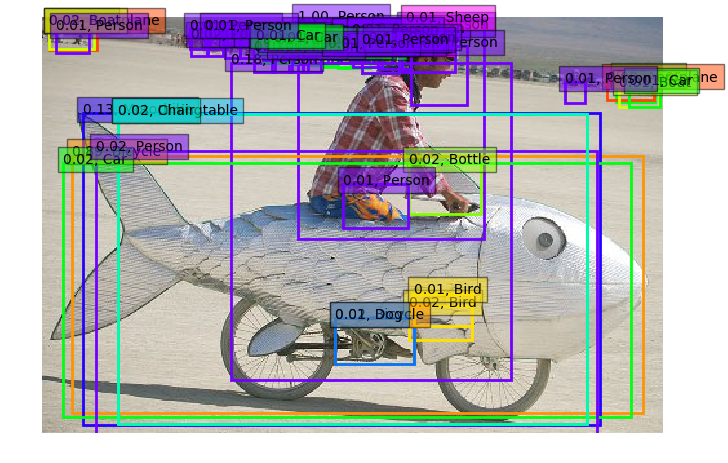

In [8]:
display_boxes(images[0],results[0],0)

**Exercise:** Try changing the value of ```nms_thresh``` to see how it changes the remaining predictions (before score thresholding).

At this point we filtered out high overlapping boxes, now let's pick the ones we want to display based on their detection confidence. Here we set a score threshold ```score_thresh``` of 0.6, and we only keep boxes with a higher score.

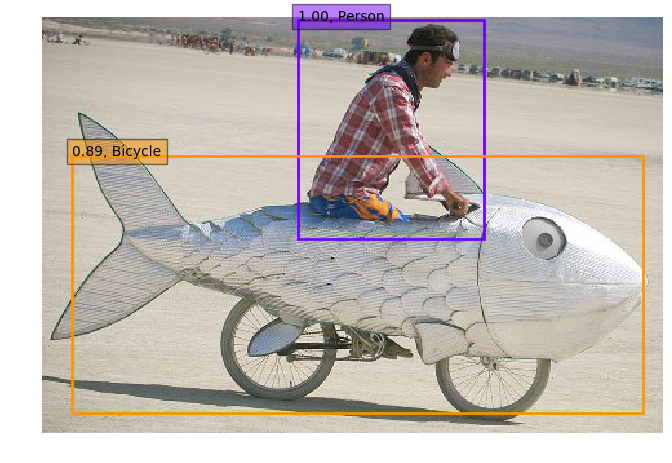

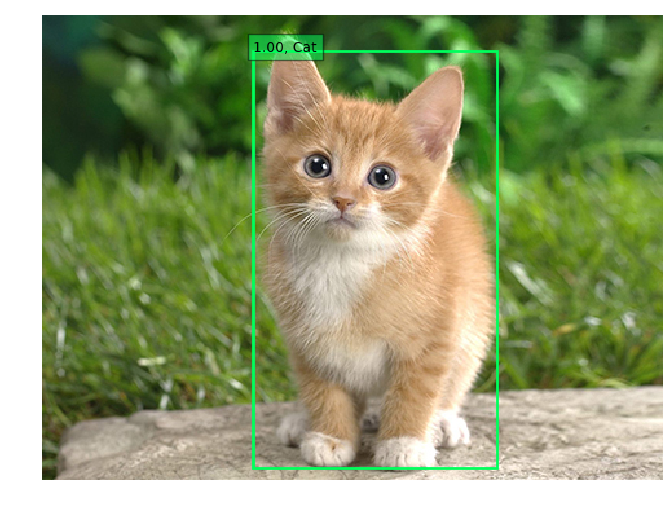

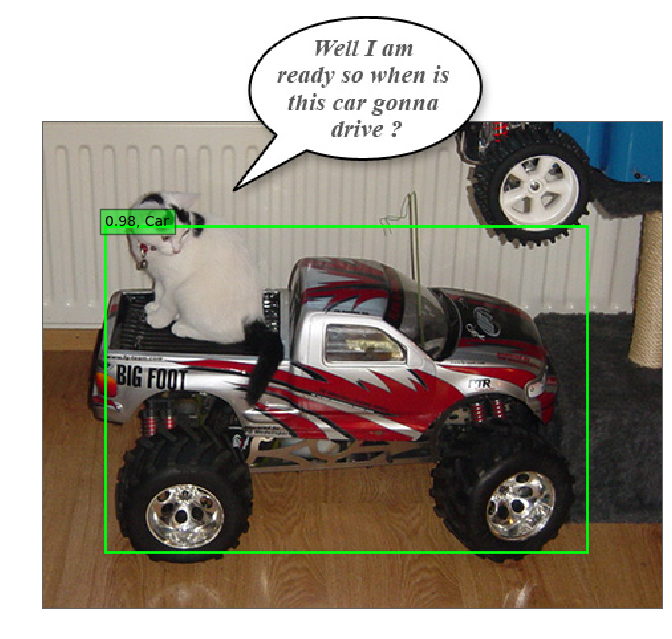

In [9]:
# min detection confidence to display
score_thresh = 0.6
for i, img in enumerate(images):
    display_boxes(img,results[i],score_thresh)

**Exercise:** Are these good results? We can see that the detector missed some objects. You can play with the different parameters that we fixed (e.g. ```nms_thresh```, ```score_thresh```) and see how they affect the results. You can also find more images in the same folder that you can test the network on.